# Data Prep

This notebook imports the complete 2019 EA Sports FIFA player database import as a csv file, cleans the data, and manipulates it for modeling. The data is also clustered using K-means clustering and labeled for a classification model.

In [2]:
# load necessary modules ----
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.core import ultratb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
%matplotlib inline

Clean the csv file and convert to usable and relevant dataframe

In [3]:
# load necessary data ----
fifa_df = pd.read_csv("write_data/all_players.csv")

# store relevant columns ----

field_indi_columns = [
        'acceleration', 'sprint_speed', 'agility', 'balance',
        'reactions', 'ball_control', 'composure', 'positioning',
        'finishing','shot_power', 'long_shots', 'volleys', 'penalties',
        'vision', 'crossing', 'free_kick', 'short_pass', 'long_pass',
        'pass_curve', 'interceptions', 'heading', 'marking', 
        'standing_tackle', 'sliding_tackle',
        'jumping', 'stamina', 'strength', 'aggression']

# clean up data frame to only contain continuous variables ----
fifa_df.columns = [name.lower().replace(" ", "_")
                   for name in fifa_df.columns]

# extract just field players from the dataframe

field_df = fifa_df[fifa_df['position'] != 'GK']

# clean up data by dropping unnecessary columns ---
field_clean_df = field_df.drop(columns=['unnamed:_0', 'club',
                                     'league','nationality', 'position',
                                      'age','preferred_foot','attacking_workrate',
                                      'defensive_workrate',
                                      'skill_moves', 'weak_foot']
                                      ).set_index('player_name')

# filter data using only the relevant columns and dromp all NaN
field_clean_df = (field_clean_df
           .filter(field_indi_columns)
           .dropna())

//anaconda3/envs/fifa-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Perform PCA to visualize clusters of players

In [4]:
# turn the cleaned dataframe into an array for matrix multiplication. ---
field_clean_arr = field_clean_df.to_numpy()

In [5]:
# define PCA then fit PCA to field player dataframe.
# 3 components gave the most explained variance. ---

pca = PCA(n_components=3, random_state=10)

pca.fit(field_clean_arr)

field_pca_df_3clust = pd.DataFrame({'pc1': np.matmul(field_clean_arr, pca.components_[0]),
                            'pc2': np.matmul(field_clean_arr, pca.components_[1]),
                            'pc3': np.matmul(field_clean_arr, pca.components_[2])},
                           index=field_clean_df.index)

# Create visualizations of the fit dataframe

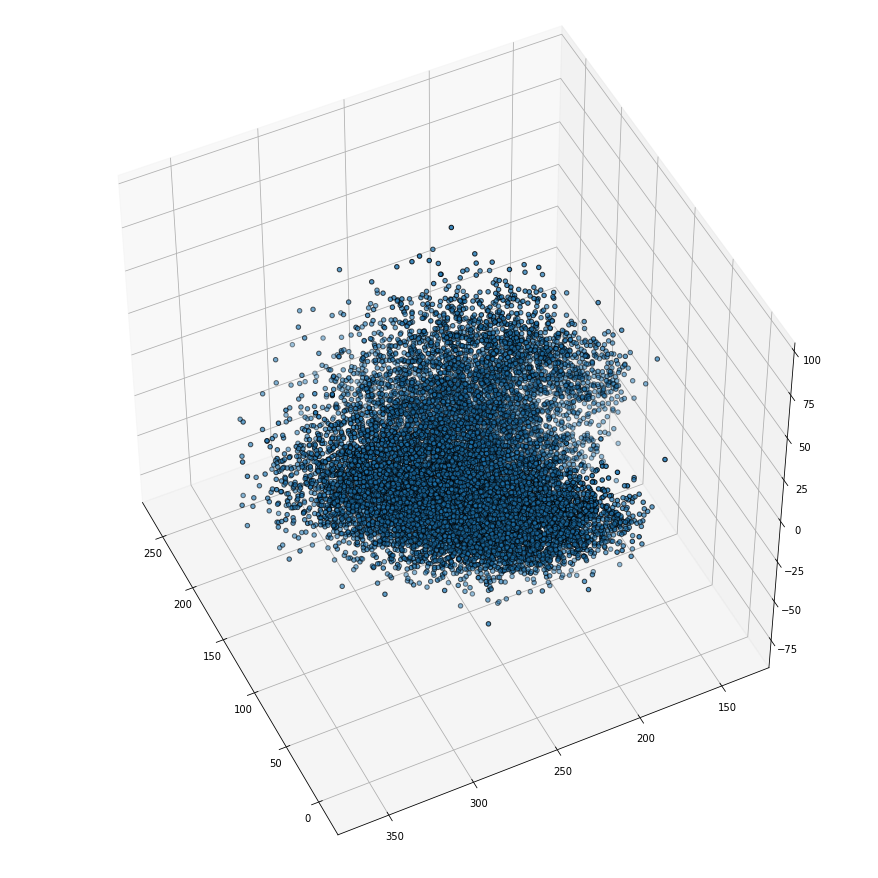

In [6]:
# plot all players ---
fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig, elev=48, azim=154)
ax.scatter(field_pca_df_3clust['pc1'],field_pca_df_3clust['pc2'],field_pca_df_3clust['pc3'], edgecolor='k')

In [7]:
# fit K-Means clusters to the fitted PCA dataframe ---
model_field = KMeans(n_clusters=5, random_state=10).fit(field_pca_df_3clust)
# define cluster centers for each cluster ---
model_field.cluster_centers_

array([[ 51.85137455, 229.2721299 ,  -9.81104153],
       [177.60475864, 245.66917771, -11.49790357],
       [132.8844394 , 297.91052255, -14.99823009],
       [ 98.64191229, 257.89679016, -23.90766989],
       [148.65978826, 197.0657626 , -12.17049452]])

In [8]:
# generate cluster index values for each row in df ---
cluster_assignments_field3 = model_field.predict(field_pca_df_3clust)
cluster_assignments_field3

array([1, 1, 2, ..., 4, 0, 0], dtype=int32)

In [9]:
# add column to original dataframe with the labeled cluster for each row ---
field_clean_df['classification'] = cluster_assignments_field3

In [20]:
# define each cluster generated ---
strong_defensive_minded = field_clean_df[field_clean_df['classification'] == 0]
technical_finishing_attackers = field_clean_df[field_clean_df['classification'] == 1]
all_rounders_passers = field_clean_df[field_clean_df['classification'] == 2]
def_ball_winners = field_clean_df[field_clean_df['classification'] == 3]
aerial_ball_skillers = field_clean_df[field_clean_df['classification'] == 4]

In [24]:
player_classifications = {0 : 'strong_defensive_minded',
                          1 : 'technical_finishing_attackers',
                          2 : 'all_rounders_passers',
                          3 : 'def_ball_winners',
                          4 : 'aerial_ball_skiller'}

In [30]:
means_field_df = field_clean_df.groupby('classification').mean().rename(player_classifications)
#means_field_df.rename(player_classifications)


In [33]:
means_field_df.to_csv('write_data/field_radar.csv')

//anaconda3/envs/fifa-env/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


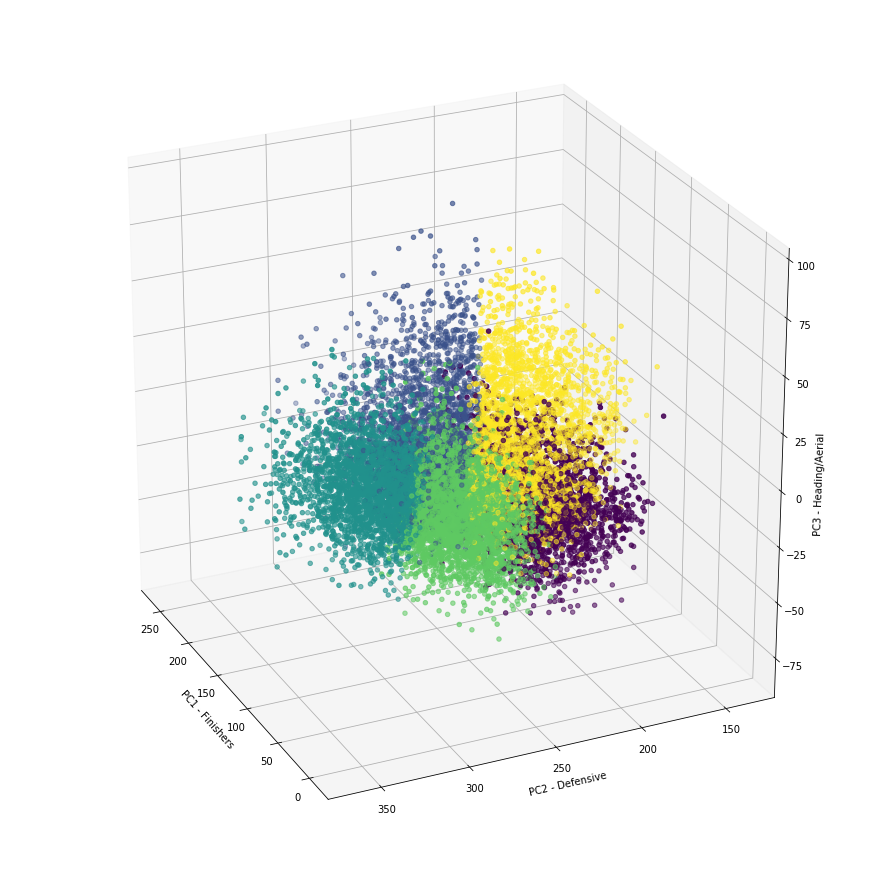

In [11]:
# plot clusters in a 3D space for visualization ---
fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig, elev=25, azim=155)
ax.set_xlabel('PC1 - Finishers')
ax.set_ylabel('PC2 - Defensive')
ax.set_zlabel('PC3 - Heading/Aerial')
ax.scatter(field_pca_df_3clust['pc1'],
           field_pca_df_3clust['pc2'],
           field_pca_df_3clust['pc3'],
           c=model_field.labels_)
for i in range(len(model_field.cluster_centers_)):
    plt.scatter(model_field.cluster_centers_[i][0], model_field.cluster_centers_[i][1],
                model_field.cluster_centers_[i][2]);


# Evaluate clusters and make professional opinion on number of clusters

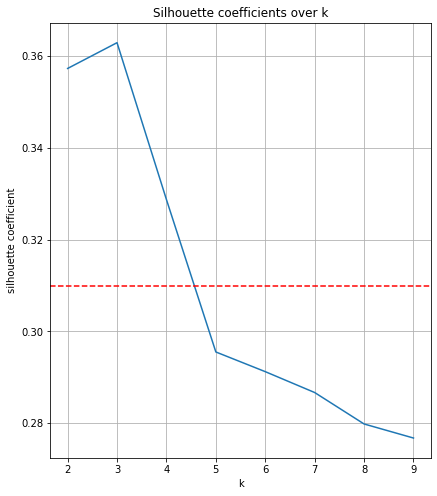

In [12]:
# build a silhouette plot for evaluation ---
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(field_pca_df_3clust)
    silhouette_avg = metrics.silhouette_score(field_pca_df_3clust, cluster_labels)
    silhouette_plot.append(silhouette_avg)

plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [13]:
# define an elbow test method to evaluate appropriate number of clusters from K-Means ---
def elbow_test(df):

    X = df
    distortions = []

# Calculate SSE for different K
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state = 10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

# Plot values of SSE
    plt.figure(figsize=(15,8))
    plt.subplot(121, title='Elbow curve')
    plt.xlabel('k')
    plt.plot(range(2, 10), distortions)
    plt.grid(True)

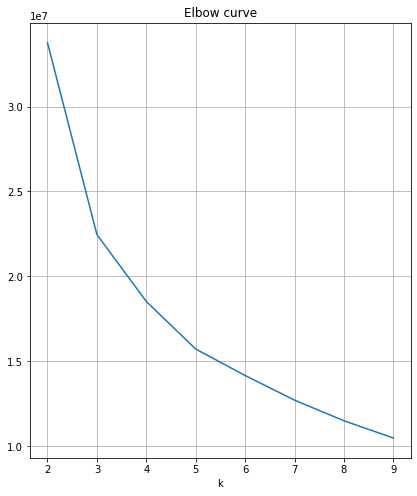

In [14]:
# perform and elbow test for cluster evaluation ---
elbow_test(field_pca_df_3clust)

In [15]:
# write csv file to be used in modeling
field_clean_df.to_csv("write_data/model_field_players.csv", index=True)

In [16]:
field_clean_df.head()

,acceleration,sprint_speed,agility,balance,reactions,ball_control,composure,positioning,finishing,shot_power,...,interceptions,heading,marking,standing_tackle,sliding_tackle,jumping,stamina,strength,aggression,classification
player_name,,,,,,,,,,,,,,,,,,,,,
Lionel Messi,92,86,91,95,95,97,97,95,96,85,...,22,72,34,28,26,69,73,59,48,1
C. Ronaldo dos Santos Aveiro,89,91,87,70,96,94,95,95,94,95,...,29,89,28,31,23,95,88,79,63,1
Kevin De Bruyne,79,76,79,77,92,92,89,88,83,92,...,61,55,68,58,51,63,91,75,76,2
Luis Suárez,87,75,82,83,94,91,85,93,95,86,...,41,78,63,45,38,69,91,83,88,1
Sergio Ramos García,77,76,79,66,86,85,81,52,60,80,...,90,92,89,93,92,94,85,83,85,2


In [26]:
field_clean_df.loc["Erling Håland"]

acceleration       77
sprint_speed       75
agility            68
balance            63
reactions          63
ball_control       64
composure          63
positioning        66
finishing          67
shot_power         66
long_shots         55
volleys            58
penalties          68
vision             57
crossing           46
free_kick          33
short_pass         60
long_pass          33
pass_curve         66
interceptions      22
heading            59
marking            38
standing_tackle    28
sliding_tackle     15
jumping            68
stamina            66
strength           84
aggression         80
classification      4
Name: Erling Håland, dtype: int64